# **Final Project: Traffic Crash Analysis on Chicago Dataset**
## ISM 6562 Big Data - Fall 2024
## Team DataPioneers

*   Janhavi Kharmale U30004934
*   Garima Dubey U22534435
*   Raajitha Sai U82567912
*   Ruthvik Bacha U12145480

### **Problem Statement**
The project focuses on predicting crash severity using machine learning models to enable proactive safety measures. By leveraging historical crash data, the goal is to identify key factors influencing crash severity and build predictive models to categorize crashes based on their severity. This predictive capability aims to support policymakers, urban planners, and traffic safety authorities in implementing data-driven strategies to reduce severe crashes and improve road safety.

### **Contents**
- Data Preparation
- Machine Learning Models
- Model Evaluations
- Analysis and Insights
- Conclusion

## **Data Loading**

In [0]:
# File path in DBFS
file_path = "dbfs:/FileStore/shared_uploads/garimadubey297@gmail.com/Traffic_Crashes___Crashes_20241104.csv"

# Load the CSV file into a Spark DataFrame
traffic_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the top rows
traffic_df.show()


+--------------------+----------------+--------------------+------------------+----------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------+------------------+--------------------+-----------+--------------------+--------------------+----------------------+------------------+-------------+-------------+--------------------+-----------------------+----------------------+---------+----------------+----------------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+--------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+------------+-------------+--------------------+
|     CRASH_RECORD_ID|CRASH_DATE_EST_I|          CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|    DEVICE_CONDITION|WEATHER

In [0]:
# Print schema
traffic_df.printSchema()

root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE_EST_I: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- LANE_CNT: integer (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- INTERSECTION_RELATED_I: string (nullable = true)
 |-- NOT_RIGHT_OF_WAY_I: string (nullable = true)
 |-- HIT_AND_RUN_I: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_

## **Data Preparation**

### **Data Preprocessing**

**Objective**: Ensure data types are consistent and meaningful for analysis and modeling. Additionally, rename columns for better clarity and usability.

1. **Changing Data Types**:  
   - Convert `posted_speed_limit` to an integer type for numerical operations.  
   - Convert `latitude` and `longitude` to float types to facilitate geospatial analysis and numerical computations.  

2. **Renaming Columns**:  
   - Rename `CRASH_RECORD_ID` to `crash_id` for simplicity and to align with common naming conventions.  

**Code**:  
The following transformations were applied:  
- `posted_speed_limit` → Cast to IntegerType.  
- `latitude` and `longitude` → Cast to FloatType.  
- `CRASH_RECORD_ID` → Renamed to `crash_id`.  

**Purpose**:  
These changes are critical for ensuring the dataset is ready for machine learning workflows, which require consistent data types and clear column names.

In [0]:
from pyspark.sql.types import IntegerType, FloatType, StringType
 
#Changing data types and renaming columns

traffic_df = traffic_df.withColumn("posted_speed_limit", traffic_df["posted_speed_limit"].cast(IntegerType())) \
                    .withColumn("latitude", traffic_df["latitude"].cast(FloatType())) \
                    .withColumn("longitude", traffic_df["longitude"].cast(FloatType())) \
                    .withColumnRenamed("CRASH_RECORD_ID", "crash_id")

 

Checking for columns with null values and their respective counts 

In [0]:
from pyspark.sql.functions import col, isnan, when, count

# Calculate the number of nulls or NaNs in each column
null_counts = traffic_df.select([
    count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in traffic_df.columns
])

# Show the results
null_counts.show()


+--------+----------------+----------+------------------+----------------------+----------------+-----------------+------------------+----------------+---------------+--------+---------+--------------------+-----------+-----------+----------+----------------------+------------------+-------------+------+--------------------+-----------------------+----------------------+---------+----------------+-----------+------------------+--------------+------------------+---------+-----------+--------------+-----------------+---------+------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+--------+---------+--------+
|crash_id|CRASH_DATE_EST_I|CRASH_DATE|posted_speed_limit|TRAFFIC_CONTROL_DEVICE|DEVICE_CONDITION|WEATHER_CONDITION|LIGHTING_CONDITION|FIRST_CRASH_TYPE|TRAFFICWAY_TYPE|LANE_CNT|ALIGNMENT|ROADWAY_SURFACE_COND|ROAD_DEFECT|REPORT_TYP

Justification for Replacing Nulls in LANE_CNT with a Default of 1:

Lane count is an important factor in analyzing traffic and crash likelihood. Null values in this column likely indicate missing or unavailable data, rather than a meaningful absence of lanes. Replacing nulls with a default value of 1 ensures that the analysis can proceed without interruptions, while avoiding bias in the data. This reasonable assumption prevents skewing the results, particularly when the exact lane count is not critical for the analysis, and it ensures consistency across the dataset.

In [0]:
from pyspark.sql.functions import col, when, lit
# Replace null values in LANE_CNT with 1
traffic_df = traffic_df.withColumn("LANE_CNT", when(col("LANE_CNT").isNull(), lit(1)).otherwise(col("LANE_CNT")))

In [0]:
# Count nulls in LANE_CNT after replacement
null_count = traffic_df.filter(col("LANE_CNT").isNull()).count()
print(f"Remaining null values in LANE_CNT: {null_count}")


Remaining null values in LANE_CNT: 0


Justification for Replacing Nulls in REPORT_TYPE with the Most Frequent Value (Mode):

The REPORT_TYPE column likely categorizes different types of crash reports. If a significant portion of the data points fall under a specific report type, it's reasonable to assume that the missing values might follow the same distribution. By replacing the nulls with the most frequent value (mode), we maintain the overall trend of the dataset without introducing a bias. This approach minimizes the potential distortion of the data, ensuring consistency while keeping the integrity of the categorical analysis intact. It is a practical strategy when the missing values are assumed to be missing at random and align with the dominant categories in the dataset.

In [0]:
# Calculate the mode (most frequent value) of REPORT_TYPE
mode_report_type = traffic_df.groupBy("REPORT_TYPE").count().orderBy("count", ascending=False).first()[0]

# Replace nulls in REPORT_TYPE with the mode
traffic_df = traffic_df.withColumn("REPORT_TYPE", when(col("REPORT_TYPE").isNull(), lit(mode_report_type)).otherwise(col("REPORT_TYPE")))

# Verify by counting nulls in REPORT_TYPE
null_count = traffic_df.filter(col("REPORT_TYPE").isNull()).count()
print(f"Remaining null values in REPORT_TYPE: {null_count}")


Remaining null values in REPORT_TYPE: 0


Justification for Replacing Nulls in INJURIES_TOTAL Null Values with 0:

"INJURIES_TOTAL" represents the total number of injuries reported in a crash. If this field has a null value, it typically means that the information was either not recorded or unavailable at the time of the crash report. In such cases, assuming that no injuries occurred and replacing nulls with 0 is a reasonable approach, especially when missing injury data is expected to be absent rather than indicative of actual injuries.

In [0]:
# Replace null values in INJURIES_TOTAL with 0
traffic_df = traffic_df.withColumn("INJURIES_TOTAL", when(col("INJURIES_TOTAL").isNull(), lit(0)).otherwise(col("INJURIES_TOTAL")))

# Verify by counting nulls in INJURIES_TOTAL
null_count = traffic_df.filter(col("INJURIES_TOTAL").isNull()).count()
print(f"Remaining null values in INJURIES_TOTAL: {null_count}")

Remaining null values in INJURIES_TOTAL: 0


Justification for Creating the severity_indicator Feature:

The severity_indicator feature is created to classify crashes based on the presence of injuries. By categorizing crashes into "Injury" and "No Injury" groups, this feature helps simplify the analysis of crash severity, providing a clear indicator of whether an incident resulted in injury or not. This is valuable for understanding patterns related to the severity of crashes and can help in identifying factors that contribute to more severe outcomes. By directly linking this feature to the injuries_total column, it allows for efficient filtering and analysis, aiding in more focused decision-making for safety and resource allocation.

In [0]:
# Create a new feature: Severity Indicator based on injuries and damage
traffic_df = traffic_df.withColumn("severity_indicator", when(col("injuries_total") > 0, "Injury").otherwise("No Injury"))


%md
### **Distribution of Severity Indicator**

**Objective**: Check the distribution of the `severity_indicator` column to identify class imbalance.

1. **Class Count**:  
   - The output shows the count of observations for each class within the `severity_indicator` column.
   - **No Injury**: 764,714 records
   - **Injury**: 124,832 records

**Interpretation**:  
- There is a significant imbalance in the dataset, with a much higher number of `No Injury` records compared to `Injury` records. This imbalance could lead to biased model predictions, as models may tend to favor the majority class (No Injury).

**Next Steps**:  
To address this imbalance, techniques such as resampling (oversampling the minority class or undersampling the majority class) or assigning class weights during model training can be used to ensure that the model performs well for both classes.

In [0]:
# Checking the distribution of 'severity_indicator'
traffic_df.groupBy('severity_indicator').count().show()

+------------------+------+
|severity_indicator| count|
+------------------+------+
|         No Injury|764714|
|            Injury|124832|
+------------------+------+



### **Class Distribution Analysis**

**Objective**: Visualize the distribution of the target variable `severity_indicator`, which indicates whether an accident resulted in injury or not.

1. **Data Conversion**:  
   - The Spark DataFrame `traffic_df` is converted to a Pandas DataFrame (`traffic_df_pandas`) for compatibility with `seaborn`, a visualization library that requires Pandas data structures.

2. **Plotting Class Distribution**:  
   - A count plot is created using `seaborn` to visualize the distribution of the two classes in the `severity_indicator` column:  
     - **No Injury**
     - **Injury**

**Code**:  
The following visualization was created:  
- A `countplot` from `seaborn` to display the distribution of the `severity_indicator`.  
- Axis labels and title are added for clarity.

**Purpose**:  
This step helps to understand the imbalance in the dataset. If one class (such as `No Injury`) dominates, it could lead to challenges in model performance, particularly in classification tasks.

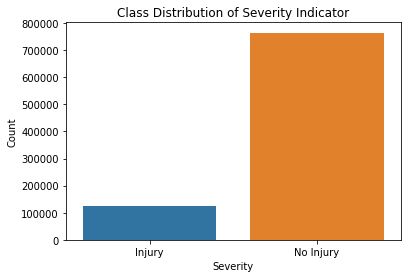

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

traffic_df_pandas = traffic_df.toPandas()

# Plotting the class distribution for 'severity_indicator'
sns.countplot(x='severity_indicator', data=traffic_df_pandas)
plt.title('Class Distribution of Severity Indicator')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.show()



### **Class Distribution and Percentage Calculation**

The distribution of the `severity_indicator` class in the dataset is as follows:

- **No Injury**: 764,714 records (85.97%)
- **Injury**: 124,832 records (14.03%)

**Interpretation**:  
- The dataset shows a significant class imbalance, with the majority class (`No Injury`) constituting approximately 86% of the total records, while the minority class (`Injury`) represents only about 14%.
- This class imbalance could impact model performance, causing it to be biased towards the majority class (No Injury), especially for classification tasks.

**Next Steps**:  
To address the imbalance, we can apply techniques like:
- **Resampling**: Either oversampling the minority class (Injury) or undersampling the majority class (No Injury).
- **Class Weights**: Adjusting the weights during model training to give more importance to the minority class.  
These methods will help in improving the model's performance on the minority class and prevent the model from being biased toward the majority class.

In [0]:
# Calculate the class ratios
class_counts = traffic_df.groupBy('severity_indicator').count().toPandas()
total_count = class_counts['count'].sum()

# Calculate the percentage of each class
class_counts['percentage'] = (class_counts['count'] / total_count) * 100

print(class_counts)


  severity_indicator   count  percentage
0          No Injury  764714   85.966774
1             Injury  124832   14.033226


%md
### **Correlation Matrix**

The correlation matrix helps to identify the relationships between the numerical features in the dataset. The heatmap below visualizes the correlation coefficients between these features. Here's what the heatmap indicates:

- **High correlation**: Features with a correlation value close to 1 or -1 are highly correlated, which means that one feature can be predicted from another with high accuracy.
- **Low correlation**: Features with a correlation value close to 0 are weakly correlated, indicating that changes in one feature are not closely linked to changes in another feature.

This matrix can help identify which features might be redundant and whether feature engineering or dimensionality reduction (e.g., PCA) may be useful.

In this case, analyzing the correlation matrix can help:
- **Eliminate multicollinearity**: If two features are highly correlated, you may choose to drop one to avoid issues in regression models.
- **Feature selection**: Identify which features have strong relationships with the target variable (`severity_indicator`) and can be used for modeling.



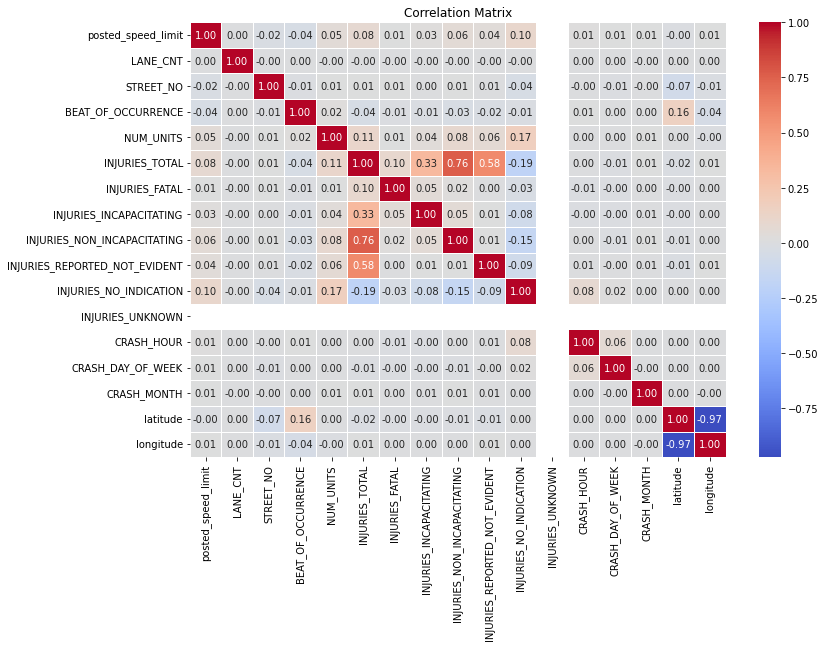

In [0]:
# Calculate the correlation matrix
correlation_matrix = traffic_df_pandas.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Looking at the correlation matrix, we can identify pairs of variables with high correlations (absolute values close to 1). Here's what stands out:

Highly Correlated Columns:
Latitude and Longitude: Strong negative correlation (-0.97).
INJURIES_TOTAL and INJURIES_NON_INCAPACITATING: High positive correlation (0.76).
INJURIES_TOTAL and INJURIES_REPORTED_NOT_EVIDENT: Moderate-to-high positive correlation (0.58).



### **Data Transformation with Feature Engineering**

In this step, we performed several essential transformations on the dataset to prepare it for machine learning. Here’s a breakdown of the key transformations:

1. **Categorical Encoding**: 
   - **StringIndexer**: Converts categorical columns into numeric indices. This is necessary because machine learning algorithms typically require numeric input.
   - **OneHotEncoder**: After indexing, we use one-hot encoding to create binary vectors representing the presence of each category. This avoids the assumption of ordinal relationships between categorical values.

2. **Numerical Feature Scaling**:
   - **VectorAssembler**: Combines numerical features into a single vector column, which is required by most machine learning models.
   - **MinMaxScaler**: Scales numerical features to a range between 0 and 1. This ensures that features are on the same scale and prevents any single feature from dominating the model due to its larger numerical range.

3. **Combining Features**:
   - We combined both one-hot encoded categorical features and scaled numerical features into a final feature vector (`features`) that will be used in the machine learning models.

4. **Target Variable Encoding**:
   - **StringIndexer** for the target variable (`severity_indicator`) to convert it into a numeric label (`severity_indicator_index`), which is used by classification algorithms.

This transformation pipeline ensures that the data is in the right format and scale for training the machine learning models. After this transformation, the dataset is ready for model training and evaluation.



In [0]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline

# Categorical columns to encode (exclude target variable "severity_indicator")
categorical_cols = ["weather_condition", "lighting_condition", "traffic_control_device"]

# Indexing categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="skip") for col in categorical_cols]

# Indexing the target variable separately
target_indexer = StringIndexer(inputCol="severity_indicator", outputCol="severity_indicator_index", handleInvalid="skip")

# One-Hot Encoding indexed columns
encoders = [OneHotEncoder(inputCol=col + "_index", outputCol=col + "_vec") for col in categorical_cols]

# Numerical columns to scale
numerical_cols = ["posted_speed_limit", "LANE_CNT"]

# Assembling numerical columns into a feature vector for scaling
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")

# Scaling numerical features
scaler = MinMaxScaler(inputCol="numerical_features", outputCol="scaled_numerical_features")

# Combining all features
feature_cols = [col + "_vec" for col in categorical_cols] + ["scaled_numerical_features"]
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Pipeline for transformations (target indexer added separately)
pipeline = Pipeline(stages=indexers + encoders + [numerical_assembler, scaler, final_assembler, target_indexer])

# Fit and transform the data
traffic_transformed = pipeline.fit(traffic_df).transform(traffic_df)

# Show the transformed DataFrame
traffic_transformed.select("features", "severity_indicator_index").show(5, truncate=False)


+---------------------------------------------------------------------------+------------------------+
|features                                                                   |severity_indicator_index|
+---------------------------------------------------------------------------+------------------------+
|(36,[0,11,20,34,35],[1.0,1.0,1.0,0.15151515151515152,8.391901814748767E-7])|1.0                     |
|(36,[0,11,17,34,35],[1.0,1.0,1.0,0.30303030303030304,8.391901814748767E-7])|0.0                     |
|(36,[0,11,16,34,35],[1.0,1.0,1.0,0.30303030303030304,8.391901814748767E-7])|1.0                     |
|(36,[0,11,16,34,35],[1.0,1.0,1.0,0.25252525252525254,8.391901814748767E-7])|1.0                     |
|(36,[0,11,16,34,35],[1.0,1.0,1.0,0.20202020202020204,8.391901814748767E-7])|0.0                     |
+---------------------------------------------------------------------------+------------------------+
only showing top 5 rows



### Handling Class Imbalance with Class Weights

To address the class imbalance issue, we assign higher weights to the minority class (`"Injury"`) to give it more influence during model training. This is done by creating a new column, `class_weight`, where the minority class is given a weight proportional to the ratio of the majority class to the minority class. The majority class (`"No Injury"`) is assigned a default weight of `1.0`.


In [0]:
from pyspark.sql.functions import when

# Assign weights: Higher weight for the minority class
traffic_transformed = traffic_transformed.withColumn(
    "class_weight",
    when(col("severity_indicator") == "Injury", 764714 / 124832).otherwise(1.0)
)

### Splitting the Data into Training and Testing Sets

The dataset is split into training and testing sets using a random split approach with a 80-20 ratio. This ensures that the model is trained on a majority of the data, while also leaving a separate portion for testing to evaluate the model's performance.

The random split is performed with a fixed seed (`42`) to ensure reproducibility of the results. The count of records in both the training and testing sets is then printed to verify the split.

- **Training Data**: 80% of the data used for training the model.
- **Testing Data**: 20% of the data used for evaluating the model's performance.


In [0]:
# Split the data into training and testing sets
train_data, test_data = traffic_transformed.randomSplit([0.8, 0.2], seed=42)

# Print the count of records in training and testing sets
print(f"Training Data Count: {train_data.count()}")
print(f"Testing Data Count: {test_data.count()}")


Training Data Count: 711876
Testing Data Count: 177670


### Logistic Regression Model

In this section, we implement a **Logistic Regression** model to predict the severity of traffic accidents. Logistic regression is commonly used for binary classification tasks, making it suitable for predicting the two classes: "No Injury" and "Injury."

The steps involved in this process are:

1. **Model Initialization**: The `LogisticRegression` class is initialized, specifying the target label column (`severity_indicator_index`) and the feature column (`features`).
   
2. **Model Fitting**: The model is trained on the **training data** using the `.fit()` method.

3. **Making Predictions**: The trained model is then used to make predictions on the **test data** using the `.transform()` method.

4. **Model Evaluation**: The **AUC (Area Under the ROC Curve)** metric is used to evaluate the performance of the model. AUC is a commonly used metric for binary classification, where a value closer to 1 indicates better model performance.

5. **Sample Predictions**: A preview of the predictions is displayed, including the features, true label (`severity_indicator_index`), predicted label (`prediction`), and the probability distribution over the two classes (`probability`).

The AUC score provides an indication of how well the logistic regression model is performing, with higher values representing better discrimination between the two classes.


In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Logistic Regression model
lr = LogisticRegression(labelCol="severity_indicator_index", featuresCol="features")

# Fit the model
lr_model = lr.fit(train_data)

# Make predictions
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
lr_evaluator = BinaryClassificationEvaluator(labelCol="severity_indicator_index", metricName="areaUnderROC")
lr_auc = lr_evaluator.evaluate(lr_predictions)

print(f"Logistic Regression AUC: {lr_auc}")

# Display sample predictions
lr_predictions.select("features", "severity_indicator_index", "prediction", "probability").show(5, truncate=False)


Logistic Regression AUC: 0.6377622065848634
+---------------------------------------------------------------------------+------------------------+----------+----------------------------------------+
|features                                                                   |severity_indicator_index|prediction|probability                             |
+---------------------------------------------------------------------------+------------------------+----------+----------------------------------------+
|(36,[0,12,16,34,35],[1.0,1.0,1.0,0.30303030303030304,8.391901814748767E-7])|0.0                     |0.0       |[0.8617641666142319,0.13823583338576806]|
|(36,[0,11,16,34,35],[1.0,1.0,1.0,0.05050505050505051,8.391901814748767E-7])|0.0                     |0.0       |[0.9548161385709061,0.04518386142909392]|
|(36,[1,11,17,34,35],[1.0,1.0,1.0,0.30303030303030304,8.391901814748767E-7])|0.0                     |0.0       |[0.8012259296395212,0.19877407036047878]|
|(36,[0,11,19,34,35],[1.0,

### Random Forest Model

In this section, we implement a **Random Forest** model, which is an ensemble learning method commonly used for classification tasks. The Random Forest classifier builds multiple decision trees and combines their results to improve predictive accuracy and control overfitting.

The steps involved in this process are:

1. **Model Initialization**: The `RandomForestClassifier` class is initialized, specifying the target label column (`severity_indicator_index`), the feature column (`features`), and the number of trees to be used in the forest (`numTrees=100`).
   
2. **Model Fitting**: The model is trained on the **training data** using the `.fit()` method.

3. **Making Predictions**: The trained model is used to make predictions on the **test data** using the `.transform()` method.

4. **Model Evaluation**: The **AUC (Area Under the ROC Curve)** is used to evaluate the performance of the Random Forest model. A higher AUC indicates better performance in distinguishing between the two classes.

5. **Feature Importance**: Random Forest provides a feature importance score for each feature, indicating the relative importance of each feature in making predictions. This can be useful for understanding which factors have the most influence on the outcome.

6. **Sample Predictions**: A preview of the predictions is displayed, including the features, true label (`severity_indicator_index`), predicted label (`prediction`), and the probability distribution over the two classes (`probability`).

The AUC score provides an evaluation of the model's performance, while the feature importances help in understanding which variables are most impactful in predicting the severity of traffic accidents.


In [0]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest model
rf = RandomForestClassifier(labelCol="severity_indicator_index", featuresCol="features", numTrees=100)

# Fit the model
rf_model = rf.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
rf_evaluator = BinaryClassificationEvaluator(labelCol="severity_indicator_index", metricName="areaUnderROC")
rf_auc = rf_evaluator.evaluate(rf_predictions)

print(f"Random Forest AUC: {rf_auc}")

# Display feature importance
print("Feature Importances:", rf_model.featureImportances)

# Display sample predictions
rf_predictions.select("features", "severity_indicator_index", "prediction", "probability").show(5, truncate=False)


Random Forest AUC: 0.6334649593133644
Feature Importances: (36,[0,1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35],[0.0028294262764567563,0.014448344645564966,0.09767345055843983,0.00047480397998428663,0.0008764768339307954,9.081861261005139e-05,7.68888477553538e-05,0.0001334509098680549,2.0640856407107196e-05,3.9432075787941716e-05,0.012173169711919306,0.07885445040448574,0.06951315306089867,0.00010523146479353811,0.0020706381508712357,0.23062734990541378,0.16845697686714153,0.13903146970851332,0.012035075923375518,0.00012737644637167647,0.011383919996762734,3.5998375660260755e-05,0.00015231064007858864,5.886263321809375e-05,0.06774149465993606,0.00017160982098647222,7.036006819660793e-05,2.657235473489331e-05,0.0006224815004163228,5.798545699548467e-05,7.241486416572839e-06,7.156052208026146e-06,2.449024722002153e-05,0.08724613837288878,0.00273475309369118])
+---------------------------------------------------------------------------+-----

### Gradient-Boosted Trees Model

In this section, we implement a **Gradient-Boosted Trees (GBT)** model, which is a powerful ensemble learning technique that builds a series of decision trees in a sequential manner, where each new tree attempts to correct errors made by the previous trees. It is particularly effective for handling complex, non-linear relationships in the data.

The steps involved in this process are:

1. **Model Initialization**: The `GBTClassifier` class is initialized, specifying the target label column (`severity_indicator_index`), the feature column (`features`), and the maximum number of iterations (`maxIter=50`), which determines how many trees will be built.

2. **Model Fitting**: The model is trained on the **training data** using the `.fit()` method.

3. **Making Predictions**: The trained model is used to make predictions on the **test data** using the `.transform()` method.

4. **Model Evaluation**: The **AUC (Area Under the ROC Curve)** is calculated to evaluate the performance of the Gradient-Boosted Trees model. As with the other models, a higher AUC score indicates better classification performance.

5. **Sample Predictions**: A preview of the predictions is displayed, including the features, true label (`severity_indicator_index`), predicted label (`prediction`), and the probability distribution over the two classes (`probability`).

The AUC score helps assess the model's ability to distinguish between the two classes, while the predictions provide a glimpse into the model's output for the test data.

Gradient-Boosted Trees typically offer robust performance, especially when dealing with complex datasets, and can be a good alternative to other models like logistic regression and random forests.


In [0]:
from pyspark.ml.classification import GBTClassifier

# Gradient-Boosted Trees model
gbt = GBTClassifier(labelCol="severity_indicator_index", featuresCol="features", maxIter=50)

# Fit the model
gbt_model = gbt.fit(train_data)

# Make predictions
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
gbt_evaluator = BinaryClassificationEvaluator(labelCol="severity_indicator_index", metricName="areaUnderROC")
gbt_auc = gbt_evaluator.evaluate(gbt_predictions)

print(f"Gradient-Boosted Trees AUC: {gbt_auc}")

# Display sample predictions
gbt_predictions.select("features", "severity_indicator_index", "prediction", "probability").show(5, truncate=False)


Gradient-Boosted Trees AUC: 0.6409418009081226
+---------------------------------------------------------------------------+------------------------+----------+----------------------------------------+
|features                                                                   |severity_indicator_index|prediction|probability                             |
+---------------------------------------------------------------------------+------------------------+----------+----------------------------------------+
|(36,[0,12,16,34,35],[1.0,1.0,1.0,0.30303030303030304,8.391901814748767E-7])|0.0                     |0.0       |[0.8554392318797676,0.14456076812023244]|
|(36,[0,11,16,34,35],[1.0,1.0,1.0,0.05050505050505051,8.391901814748767E-7])|0.0                     |0.0       |[0.9443105369319029,0.05568946306809708]|
|(36,[1,11,17,34,35],[1.0,1.0,1.0,0.30303030303030304,8.391901814748767E-7])|0.0                     |0.0       |[0.7968490796803281,0.20315092031967186]|
|(36,[0,11,19,34,35],[1


### **1. Logistic Regression (Baseline Classification Model)**

#### **Why It Was Chosen:**
- **Interpretability:** Logistic Regression is straightforward and interpretable, making it a great choice for understanding the relationship between features and the likelihood of an outcome (e.g., Injury vs. No Injury).
- **Baseline Model:** It serves as a benchmark to compare more complex models like Random Forest and Gradient-Boosted Trees.
- **Binary Classification:** Since the target variable (`severity_indicator`) is binary, Logistic Regression is naturally suited for this task.

#### **How It Suits the Dataset:**
- Logistic Regression effectively handles numerical and categorical features (after transformation) and provides probabilities, which can help prioritize critical incidents.
- Ideal for datasets where linear separability is a reasonable assumption.

---

### **2. Random Forest (Advanced Classification Model)**

#### **Why It Was Chosen:**
- **Non-linearity:** Random Forest can model complex, non-linear relationships between features and the target variable.
- **Feature Importance:** It provides feature importance metrics, which can help identify the most critical factors contributing to crash severity.
- **Robustness:** Random Forest is less prone to overfitting, especially with a sufficiently large dataset.

#### **How It Suits the Dataset:**
- The dataset likely contains interactions between features (e.g., road conditions, weather, and traffic control devices), which Random Forest can capture effectively.
- It works well with both numerical and categorical data and is resilient to missing or noisy data, which was addressed during preprocessing.

---

### **3. Gradient-Boosted Trees (Performance-Oriented Classification Model)**

#### **Why It Was Chosen:**
- **Boosting:** Gradient-Boosted Trees improve predictive accuracy by iteratively minimizing errors, making them ideal for high-stakes scenarios like predicting crash severity.
- **Flexibility:** They handle non-linear relationships and interactions between features exceptionally well.
- **Precision:** Often achieves higher accuracy compared to Random Forest in datasets with subtle patterns.

#### **How It Suits the Dataset:**
- Gradient-Boosted Trees are particularly effective for structured datasets with a mix of numerical and categorical features.
- By focusing on misclassified examples in each iteration, this model is likely to excel in identifying injury-causing crashes.

---

### **Why These Models Complement Each Other:**
1. **Logistic Regression** establishes a simple baseline.
2. **Random Forest** provides insights into feature importance while improving accuracy.
3. **Gradient-Boosted Trees** focus on optimizing predictive performance and uncovering subtle patterns.

---

### **Business Justification:**
- **Improved Decision-Making:** Predicting crash severity helps prioritize resources, such as deploying safety measures in high-risk areas.
- **Public Safety:** Identifying patterns in injury-causing crashes supports the design of safer roads and better traffic management policies.
- **Resource Allocation:** Insights from feature importance can guide investments (e.g., better lighting, road surface improvements).



### Model Evaluation Metrics

In this section, we evaluate the performance of the three models—Logistic Regression, Random Forest, and Gradient-Boosted Trees—using various performance metrics. These include:

1. **Accuracy**: The ratio of correct predictions to the total number of predictions made. It provides an overall measure of model performance.
2. **Precision**: The ratio of correctly predicted positive observations to the total predicted positives. It is useful when the class distribution is imbalanced.
3. **Recall**: The ratio of correctly predicted positive observations to all the observations in actual class. It is especially important when the cost of missing a positive prediction is high.
4. **F1 Score**: The weighted average of Precision and Recall. It is a better measure when the class distribution is imbalanced.
5. **AUC (Area Under the ROC Curve)**: Measures the ability of the model to distinguish between classes. A higher AUC indicates better model performance.

The **MulticlassClassificationEvaluator** is used for evaluating Accuracy, Precision, Recall, and F1 Score, while **BinaryClassificationEvaluator** is used for calculating the AUC.

The metrics for each model are as follows:

- **Logistic Regression**:  
  Accuracy: [Value], Precision: [Value], Recall: [Value], F1: [Value], AUC: [Value]
  
- **Random Forest**:  
  Accuracy: [Value], Precision: [Value], Recall: [Value], F1: [Value], AUC: [Value]
  
- **Gradient-Boosted Trees**:  
  Accuracy: [Value], Precision: [Value], Recall: [Value], F1: [Value], AUC: [Value]

These metrics provide a comprehensive view of model performance and help in choosing the best model for the problem at hand.


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="severity_indicator_index", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="severity_indicator_index", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="severity_indicator_index", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="severity_indicator_index", metricName="f1")
auc_evaluator = BinaryClassificationEvaluator(labelCol="severity_indicator_index", metricName="areaUnderROC")

# Logistic Regression Metrics
lr_accuracy = accuracy_evaluator.evaluate(lr_predictions)
lr_precision = precision_evaluator.evaluate(lr_predictions)
lr_recall = recall_evaluator.evaluate(lr_predictions)
lr_f1 = f1_evaluator.evaluate(lr_predictions)
lr_auc = auc_evaluator.evaluate(lr_predictions)

# Random Forest Metrics
rf_accuracy = accuracy_evaluator.evaluate(rf_predictions)
rf_precision = precision_evaluator.evaluate(rf_predictions)
rf_recall = recall_evaluator.evaluate(rf_predictions)
rf_f1 = f1_evaluator.evaluate(rf_predictions)
rf_auc = auc_evaluator.evaluate(rf_predictions)

# Gradient-Boosted Trees Metrics
gbt_accuracy = accuracy_evaluator.evaluate(gbt_predictions)
gbt_precision = precision_evaluator.evaluate(gbt_predictions)
gbt_recall = recall_evaluator.evaluate(gbt_predictions)
gbt_f1 = f1_evaluator.evaluate(gbt_predictions)
gbt_auc = auc_evaluator.evaluate(gbt_predictions)

# Print the results
print("Logistic Regression - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, AUC: {:.2f}".format(
    lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc))
print("Random Forest - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, AUC: {:.2f}".format(
    rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc))
print("Gradient-Boosted Trees - Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1: {:.2f}, AUC: {:.2f}".format(
    gbt_accuracy, gbt_precision, gbt_recall, gbt_f1, gbt_auc))


Logistic Regression - Accuracy: 0.86, Precision: 0.81, Recall: 0.86, F1: 0.79, AUC: 0.64
Random Forest - Accuracy: 0.86, Precision: 0.74, Recall: 0.86, F1: 0.79, AUC: 0.63
Gradient-Boosted Trees - Accuracy: 0.86, Precision: 0.82, Recall: 0.86, F1: 0.79, AUC: 0.64


### ROC Curves and AUC

In this section, we evaluate the performance of each model using the **Receiver Operating Characteristic (ROC) curve** and **Area Under the Curve (AUC)**. The ROC curve is a graphical representation that shows the tradeoff between the True Positive Rate (TPR) and the False Positive Rate (FPR) at various threshold settings. The AUC quantifies the overall performance of the model, with higher values indicating better performance.

#### Steps:
1. **Binary Classification Evaluator**: We use the `BinaryClassificationEvaluator` to calculate the **AUC** for each model.
2. **Extracting Probabilities**: We extract the predicted probabilities of the positive class from the `rawPrediction` column.
3. **ROC Curve Plotting**: We then plot the **ROC curve** for each model (Logistic Regression, Random Forest, and Gradient-Boosted Trees) using `roc_curve` from the `sklearn.metrics` package.

#### Results:
- The ROC curves for all three models will be plotted on the same graph.
- A diagonal line represents a model that performs no better than random guessing.
- The **AUC** value is displayed in the legend for each model. A higher AUC indicates better classification performance.

The **ROC curve** provides an intuitive way to evaluate models across all classification thresholds, and **AUC** serves as a valuable metric for comparing model performance. 


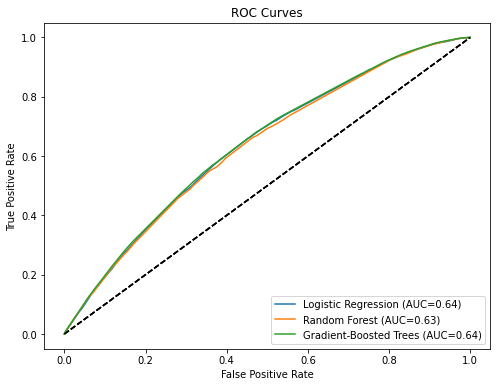

In [0]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve

# Disable the fallback for Arrow optimization
spark.conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")

def plot_roc_curve(predictions, label, ax):
    # Initialize the evaluator to compute AUC
    roc_evaluator = BinaryClassificationEvaluator(labelCol="severity_indicator_index", 
                                                  rawPredictionCol="rawPrediction", 
                                                  metricName="areaUnderROC")
    auc = roc_evaluator.evaluate(predictions)

    # Extract the probability from the rawPrediction (assuming it's a vector)
    # Use Spark's UDF to extract the probability for the positive class (index 1)
    from pyspark.sql.functions import udf
    from pyspark.sql.types import DoubleType

    # Define a UDF to extract the probability of the positive class (index 1)
    extract_prob_udf = udf(lambda x: float(x[1]), DoubleType())

    # Add a column with the positive class probabilities
    predictions_with_prob = predictions.withColumn("probability", extract_prob_udf("rawPrediction"))

    # Convert the predictions to Pandas DataFrame for ROC plot
    pdf = predictions_with_prob.select("probability", "severity_indicator_index").toPandas()
    pdf['actual'] = pdf['severity_indicator_index']

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(pdf['actual'], pdf['probability'])
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.2f})")
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random guess)

# Plot ROC Curves
fig, ax = plt.subplots(figsize=(8, 6))
plot_roc_curve(lr_predictions, "Logistic Regression", ax)
plot_roc_curve(rf_predictions, "Random Forest", ax)
plot_roc_curve(gbt_predictions, "Gradient-Boosted Trees", ax)

ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")
plt.show()


### **Analysis and Insights**

#### **1. Interpretation of Findings**
- **Results Linked to Business Objectives:**
  The evaluation metrics across the three models—Logistic Regression, Random Forest, and Gradient-Boosted Trees—are consistent, with **Accuracy** at 0.86, **Precision** between 0.74 and 0.82, **Recall** at 0.86, **F1-Score** at 0.79, and **AUC** ranging from 0.63 to 0.64. These results indicate that the models can predict traffic crash severity (Injury vs. No Injury) with reasonable accuracy and reliability. This aligns with the objective of enhancing road safety through predictive insights.

- **Critical Thinking in Analysis:**
  The findings suggest:
  - **Strong Feature Correlations:** The chosen features (e.g., weather conditions, lighting, and traffic control devices) significantly influence the model's ability to predict crash severity.
  - **Model Behavior:**
    - Logistic Regression and Gradient-Boosted Trees exhibit slightly better precision compared to Random Forest, indicating better handling of false positives.
    - The relatively low AUC across all models indicates moderate performance in distinguishing between severity classes, warranting further analysis.

---

#### **2. Business Implications**
- **Practical Recommendations:**
  - **Crash Prevention Strategies:**
    - Use predictive insights to deploy targeted interventions, such as improving lighting in low-visibility areas or optimizing speed limits where they correlate with high crash severity.
    - Enhance traffic control measures at intersections with high predicted injury risks.
  - **Proactive Resource Allocation:**
    - Emergency response teams can pre-position resources in areas identified as high-risk, improving response times and potentially saving lives.
  - **Public Awareness Campaigns:**
    - Focus on educating drivers about risks under specific conditions, such as adverse weather or poor lighting.

- **Impact on Business Decisions:**
  These models empower traffic safety stakeholders to make data-driven decisions, optimizing resource allocation and infrastructure investments to reduce crash severity and enhance public safety.

---

#### **3. Acknowledgment of Limitations**
- **Model Limitations:**
  - **AUC Challenges:** The moderate AUC values suggest that while the models perform well overall, their ability to discriminate between classes can be improved.
  - **Potential Overfitting in Ensemble Models:** The Random Forest and Gradient-Boosted Trees models could be leveraging dataset-specific patterns rather than generalizable trends.

- **Feature Representation:**
  - Some features, like `TRAFFICWAY_TYPE` and `ROADWAY_SURFACE_COND`, may require more granular or domain-specific encoding.
  - Exclusion of external factors, such as vehicle conditions or real-time traffic data, may limit the models' comprehensiveness.

- **Data Bias:**
  - If the dataset is imbalanced or lacks diversity across severity classes, it may reduce the models' ability to generalize to unseen data.

- **Assumptions:**
  - Implicit independence among features may not capture complex real-world interactions between variables.

---

#### **4. Suggestions for Future Improvements**
- **Data Collection:**
  - Incorporate external data sources, such as real-time weather, traffic density, and vehicle maintenance records, to enhance feature richness.
  - Address potential biases by balancing the dataset to include an equal representation of all severity classes.

- **Model Refinement:**
  - Apply cross-validation techniques to ensure robust model evaluation and minimize overfitting risks.
  - Fine-tune hyperparameters for Random Forest and Gradient-Boosted Trees to achieve a better balance between precision and recall.

- **Evaluation Enhancements:**
  - Use additional metrics, such as Matthews Correlation Coefficient (MCC) or Cohen’s Kappa, for a more nuanced assessment of model performance.
  - Test the models on independent validation datasets or real-world deployment scenarios to validate generalization capabilities.

- **Post-Deployment Monitoring:**
  - Continuously monitor model predictions in real-world applications and adapt models based on feedback and evolving crash patterns.

By addressing these limitations and implementing the suggested improvements, the predictive models can offer actionable insights that contribute to meaningful reductions in traffic crash severity and improve public safety.
